# Preparation

In [44]:
%matplotlib inline
import pandas as pd
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
import seaborn as sns


In [74]:
geo = pd.read_csv("data/NYCTAXI202401-202403.geo")
geo.head()

,geo_id,type,coordinates
0,0,Polygon,"[[['-74.18445300', '40.69499600'], ['-74.18563..."
1,1,MultiPolygon,"[[[['-73.81768667', '40.61493300'], ['-73.8165..."
2,2,Polygon,"[[['-73.84240629', '40.86847474'], ['-73.84280..."
3,3,Polygon,"[[['-73.97464721', '40.71884235'], ['-73.97347..."
4,4,Polygon,"[[['-74.17225508', '40.56170484'], ['-74.17348..."


In [45]:
rel = pd.read_csv("data/NYCTAXI202401-202403.rel")
rel.head()

,rel_id,type,origin_id,destination_id,cost
0,0,geo,0,0,0.0
1,1,geo,0,1,31349.0
2,2,geo,0,2,33747.0
3,3,geo,0,3,17205.0
4,4,geo,0,4,14927.0


In [46]:
df_total = pd.read_csv("data/total/NYCTAXI_OD_Total.csv")

df_earlymorning = pd.read_csv("data/timeperiod/NYCTAXI_OD_Early Morning.csv")
df_morningrush = pd.read_csv("data/timeperiod/NYCTAXI_OD_Morning Rush.csv")
df_morningtonoon = pd.read_csv("data/timeperiod/NYCTAXI_OD_Morning to Noon.csv")
df_afternoon = pd.read_csv("data/timeperiod/NYCTAXI_OD_Afternoon.csv")
df_eveningrush = pd.read_csv("data/timeperiod/NYCTAXI_OD_Evening Rush.csv")
df_night = pd.read_csv("data/timeperiod/NYCTAXI_OD_Night.csv")

# df_total["flow"].value_counts()
# df_total["origin_id"].nunique()

In [47]:
df_total

,origin_id,destination_id,flow
0,0,47,0.000916
1,0,99,0.000458
2,0,186,0.000458
3,0,208,0.000458
4,0,230,0.000458
...,...,...,...
25966,262,257,0.002290
25967,262,258,0.004123
25968,262,259,0.017865
25969,262,260,0.069629


In [48]:
# df_afternoon.drop(columns=["Unnamed: 0"], inplace=True)
df_afternoon["flow"].value_counts()

flow
0.002747    4687
0.005495    1723
0.008242     856
0.010989     578
0.013736     378
            ... 
1.703297       1
3.159341       1
1.467033       1
6.030220       1
6.233516       1
Name: count, Length: 1059, dtype: int64

# Construct network

In [49]:
G_total = nx.DiGraph()

G_earlymorning = nx.DiGraph()
G_morningrush = nx.DiGraph()
G_morningtonoon = nx.DiGraph()
G_afternoon = nx.DiGraph()
G_eveningrush = nx.DiGraph()
G_night = nx.DiGraph()

In [50]:
def construct_graph(G, df):
    for i, row in df.iterrows():
        G.add_edge(row["origin_id"], row["destination_id"], flow=row["flow"])
    # G.add_nodes_from(rel["origin_id"].unique())
    
construct_graph(G_total, df_total)

construct_graph(G_earlymorning, df_earlymorning)
construct_graph(G_morningrush, df_morningrush)
construct_graph(G_morningtonoon, df_morningtonoon)
construct_graph(G_afternoon, df_afternoon)
construct_graph(G_eveningrush, df_eveningrush)
construct_graph(G_night, df_night)

In [51]:
nx.write_gexf(G_total,"data/total/NYCTAXI_OD_Total.gexf")

nx.write_gexf(G_earlymorning,"data/timeperiod/NYCTAXI_OD_Early Morning.gexf")
nx.write_gexf(G_morningrush,"data/timeperiod/NYCTAXI_OD_Morning Rush.gexf")
nx.write_gexf(G_morningtonoon,"data/timeperiod/NYCTAXI_OD_Morning to Noon.gexf")
nx.write_gexf(G_afternoon,"data/timeperiod/NYCTAXI_OD_Afternoon.gexf")
nx.write_gexf(G_eveningrush,"data/timeperiod/NYCTAXI_OD_Evening Rush.gexf")
nx.write_gexf(G_night,"data/timeperiod/NYCTAXI_OD_Night.gexf")

In [52]:
# 服务器上不可用
# stylized_network, config = nw.visualize(G_afternoon, plot_in_cell_below=False)
# fig, ax = nw.draw_netwulf(stylized_network, figsize=(10,10))
# plt.savefig("myfigure.pdf")

In [53]:
# df_afternoon[df_afternoon["destination_id"] == 238]

In [54]:
# G_afternoon.edges(238,data=True)

# Basic statistics

## calculate

In [55]:
def get_network_statistics(G):
    # 基本统计量
    num_nodes = G.number_of_nodes()  # 节点数量
    num_edges = G.number_of_edges()  # 边数量

    # 平均度
    avg_degree = sum(dict(G.degree(weight = "flow")).values()) / num_nodes

    in_degrees = [deg for node, deg in G.in_degree(weight = "flow")]
    out_degrees = [deg for node, deg in G.out_degree(weight = "flow")]
    avg_in_degree = sum(in_degrees) / len(in_degrees)
    avg_out_degree = sum(out_degrees) / len(out_degrees)

    # Hubs（度数最高的节点）
    degree_dict = dict(G.degree(weight = "flow"))
    hubs = [node for node, degree in degree_dict.items() if degree == max(degree_dict.values())]
    in_degree_dict = dict(G.in_degree(weight = "flow"))
    in_hubs = [node for node, degree in in_degree_dict.items() if degree == max(in_degree_dict.values())]
    out_degree_dict = dict(G.out_degree(weight = "flow"))
    out_hubs = [node for node, degree in out_degree_dict.items() if degree == max(out_degree_dict.values())]

    # 最短路径长度
    shortest_path_lengths = dict(nx.shortest_path_length(G))

    # 直径（最长的最短路径长度）
    try:
        diameter = nx.diameter(G)
    except:
        diameter = "Network is not connected."

    return {
        "Number of nodes": num_nodes,
        "Number of edges": num_edges,
        "Average degree": avg_degree,
        "Average inout-degree": avg_in_degree,
        "Hubs": hubs,
        "In_hubs": in_hubs,
        "Out_hubs": out_hubs,
        # "Shortest path lengths": shortest_path_lengths,
        "Diameter": diameter
    }

def print_statistics(G):
    print("-"*45)
    stats = get_network_statistics(G)
    for key, value in stats.items():
        print(f"{key}: {value}")
    return stats

In [56]:
G_total_stats = print_statistics(G_total)

G_earlymorning_stats = print_statistics(G_earlymorning)
G_morningrush_stats = print_statistics(G_morningrush)
G_morningtonoon_stats = print_statistics(G_morningtonoon)
G_afternoon_stats = print_statistics(G_afternoon)
G_eveningrush_stats = print_statistics(G_eveningrush)
G_night_stats = print_statistics(G_night)

---------------------------------------------
Number of nodes: 260
Number of edges: 25971
Average degree: 23.3665139715987
Average inout-degree: 11.683256985799359
Hubs: [236.0]
In_hubs: [235.0]
Out_hubs: [160.0]
Diameter: Network is not connected.
---------------------------------------------
Number of nodes: 258
Number of edges: 15154
Average degree: 8.081243230744885
Average inout-degree: 4.04062161537244
Hubs: [78.0]
In_hubs: [78.0]
Out_hubs: [78.0]
Diameter: Network is not connected.
---------------------------------------------
Number of nodes: 255
Number of edges: 14070
Average degree: 21.57830209006678
Average inout-degree: 10.789151045033401
Hubs: [235.0]
In_hubs: [160.0]
Out_hubs: [235.0]
Diameter: Network is not connected.
---------------------------------------------
Number of nodes: 252
Number of edges: 11080
Average degree: 28.594104308389987
Average inout-degree: 14.297052154195006
Hubs: [236.0]
In_hubs: [236.0]
Out_hubs: [235.0]
Diameter: Network is not connected.
-----

In [57]:
df_statistics = pd.DataFrame(
    [G_total_stats, G_earlymorning_stats, G_morningrush_stats, G_morningtonoon_stats, G_afternoon_stats, G_eveningrush_stats, G_night_stats],
    index=["Total", "Early Morning", "Morning Rush", "Morning to Noon", "Afternoon", "Evening Rush", "Night"]
)
df_statistics

,Number of nodes,Number of edges,Average degree,Average inout-degree,Hubs,In_hubs,Out_hubs,Diameter
Total,260,25971,23.366514,11.683257,[236.0],[235.0],[160.0],Network is not connected.
Early Morning,258,15154,8.081243,4.040622,[78.0],[78.0],[78.0],Network is not connected.
Morning Rush,255,14070,21.578302,10.789151,[235.0],[160.0],[235.0],Network is not connected.
Morning to Noon,252,11080,28.594104,14.297052,[236.0],[236.0],[235.0],Network is not connected.
Afternoon,255,13389,31.936738,15.968369,[236.0],[235.0],[236.0],Network is not connected.
Evening Rush,252,12076,39.766818,19.883409,[160.0],[235.0],[160.0],Network is not connected.
Night,258,14630,31.175839,15.587919,[160.0],[235.0],[160.0],Network is not connected.


## plot

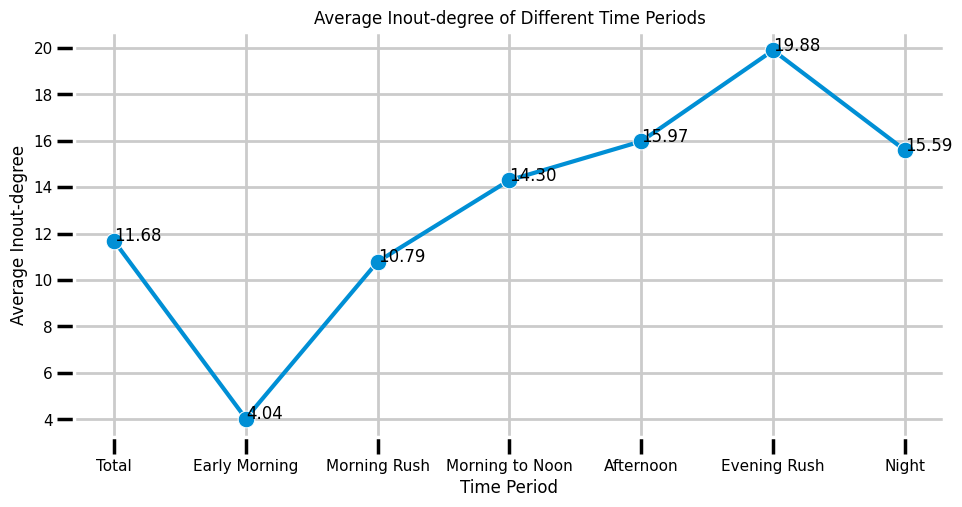

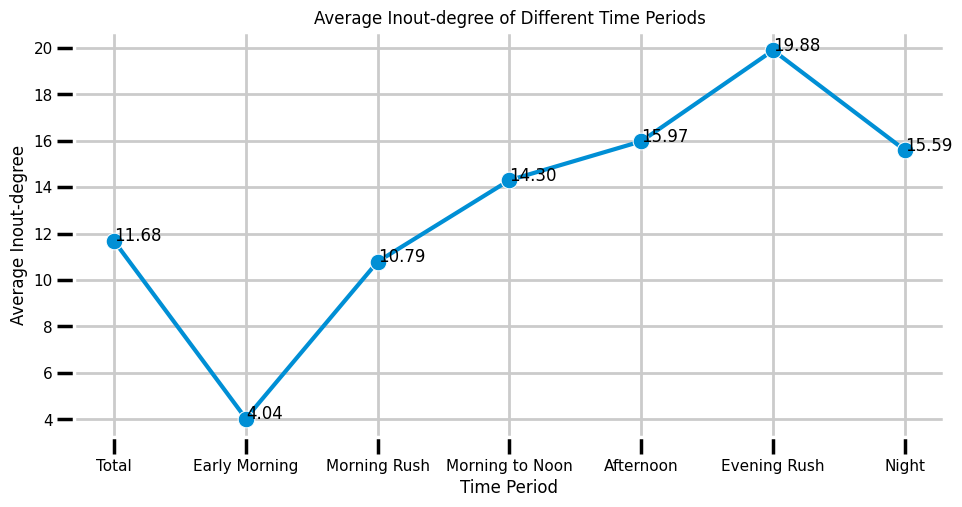

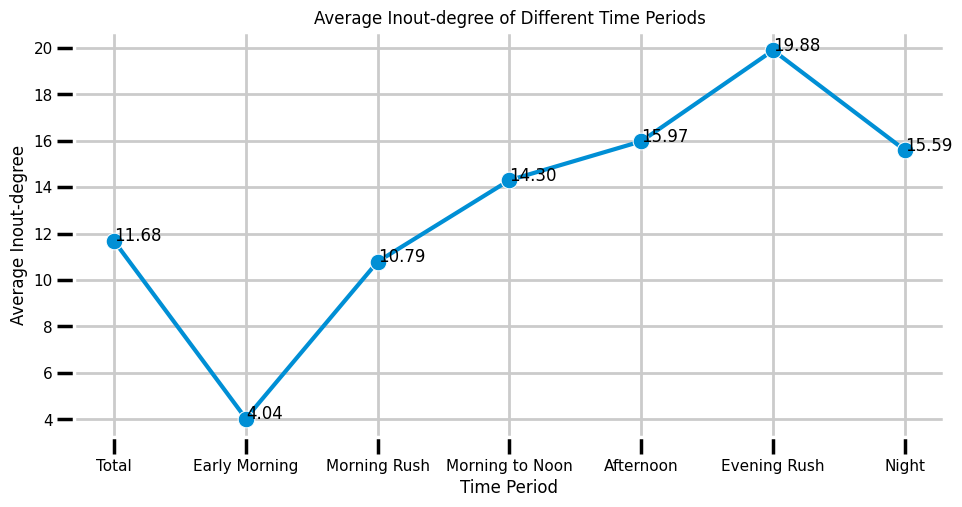

In [58]:
with plt.style.context("fivethirtyeight"), sns.plotting_context(context="poster",font_scale=0.5):
    fig,ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('white')  # 设置整个图的背景颜色为白色
    line = sns.lineplot(x=df_statistics.index, y="Average inout-degree", data=df_statistics,marker = "o")
    
    ax.set_facecolor('white')    # 设置轴的边框颜色为白色
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        
    for x, y in zip(df_statistics.index, df_statistics["Average inout-degree"]):
        ax.text(x, y, f'{y:.2f}', color='black', ha='left')
    plt.xlabel("Time Period")
    plt.ylabel("Average Inout-degree")
    plt.title("Average Inout-degree of Different Time Periods")

# Structure

在有向图中，节点i的聚类系数定义为所有可能的有向三元组（即i -> j, j -> k, k -> i）的比例，其中j和k是i的邻居。一个有向三元组是一个节点对的有序三元组。

nx.average_clustering()函数默认会将有向图视为无向图进行计算。如果你想要计算有向图的聚类系数，需要将count_zeros参数设置为False

In [59]:
# avg_clustering = nx.average_clustering(G, count_zeros=False)
# avg_clustering

# Community

In [61]:
partition = nx.community.greedy_modularity_communities(G_total)
len(partition)

3

In [72]:
# Add community to node attributes
for i, comm in enumerate(partition):
    for node in comm:
        G_total.nodes[node]['community'] = i

# Write to GEXF file
nx.write_gexf(G_total, 'data/total/NYCTAXI_OD_Total.gexf')

In [69]:
len(partition[1])
len(partition[0])
len(partition[2])

52

In [71]:
nx.community.quality.modularity(G_total, partition)

0.14322442897507343

In [80]:
for i, comm in enumerate(partition):
    for node in comm:
        geo.loc[geo["geo_id"]==node,"community"] = str(i)

In [82]:
geo[["geo_id","community"]].to_csv("data/geo_communuities.csv",index=False)